In [ ]:
# NEURAL NETWORKS & DEEP LEARNING / ECS659U COURSEWORK ASSESSMENT NOTEBOOK
# Rai Muhammad Ibrahim Badar
# 190071703

In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/NNDL')

Mounted at /content/gdrive


In [ ]:
import my_utils as mu
import torch
import math
from torchvision import transforms

In [ ]:
class Stem(torch.nn.Module):
  '''
    The stem takes in a batch of images, divides each image into a number of patches(4) of size
    KxK(14x14). These patches are then vectorised, so each image is in the form 4 x 196, all the
    patches for all the images are then stored in X. X is then passed through a linear layer which
    converts each patch vector into a feature vector. All these feature vectors for all the images
    are batch normalised and stored in X. X is then returned.
  '''
  def __init__(self, image_dims, num_patches, patch_dims, num_hidden):
    super(Stem, self).__init__()
    self.image_dims = image_dims
    self.num_patches = num_patches
    self.patch_dims = patch_dims
    self.num_hidden = num_hidden
    self.f_linear_layer = torch.nn.Linear(patch_dims**2, num_hidden[0])
    self.batch_norm = torch.nn.BatchNorm1d(num_patches)

  def forward(self, input):
    # View the input as (batch number, 28, 28)
    input = input.view(-1, self.image_dims, self.image_dims)
    # Create empty tensor that will store feature vectors of each patch
    X = torch.empty(input.shape[0], self.num_patches, self.patch_dims**2)
    for i in range(X.shape[0]):
      # Create 4 patches of each image in the batch
      patches = input[i].unfold(1, self.patch_dims, self.patch_dims).unfold(2, self.patch_dims, self.patch_dims)
      # Reshape the patches as vectors
      patch_vector = patches.reshape(-1, self.patch_dims**2)
      # Add patches to tensor X
      X[i] = patch_vector
    # Change patch vectors inside tensor X into feature vectors for each image in the batch
    X = self.f_linear_layer(X)
    X = self.batch_norm(X)
    return X

class Transpose(torch.nn.Module):
  ''' 
    Returns the transpose of the input along the dimension 1 and 2 used in the backbone
  '''
  def forward(self, input):
    return input.transpose(1,2)

class BackBone(torch.nn.Module):
  '''
    The backbone consists of two MLPS:
    MLP 1 transposes the input, passes it through a linear layer
    (the outputs of the linear layer are stored in num_hidden array), then passes it througgh the
    ReLU actiavtion function. The output of this goes through a dropout layer and is then batch
    normalised. It then passes this ouput to another linear layer, which again goes through a dropout
    layer and is batch normalised. The output of this is then transposed again and passed to MLP 2.
    
    MLP2 passes the input through another linear layer and then through another ReLU activation
    function. The output then goes through a dropout layer and is batch normalised. This is followed
    by another linear layer, another dropout layer and another batch normalisation. The output of MLP 2
    is then returned.
  '''
  def __init__(self, num_patches, num_hidden):
    super(BackBone, self).__init__()
    self.num_patches = num_patches
    self.num_hidden = num_hidden
    self.MLP1 = torch.nn.Sequential(
        Transpose(),
        torch.nn.Linear(num_patches, num_hidden[1]),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.01),
        torch.nn.BatchNorm1d(num_hidden[0]),
        torch.nn.Linear(num_hidden[1], num_hidden[2]),
        torch.nn.Dropout(p=0.01),
        torch.nn.BatchNorm1d(num_hidden[0]),
        Transpose()
    )
    self.MLP2 = torch.nn.Sequential(
        torch.nn.Linear(num_hidden[0], num_hidden[3]),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.01),
        torch.nn.BatchNorm1d(num_hidden[2]),
        torch.nn.Linear(num_hidden[3], num_hidden[4]),
        torch.nn.Dropout(p=0.01),
        torch.nn.BatchNorm1d(num_hidden[2]),
    )

  def forward(self, input):
    O1 = self.MLP1(input)
    O2 = self.MLP2(O1)
    return O2

class Classifier(torch.nn.Module):
  '''
    The classifier calculates the mean of all the feature vectures for each image,
    the mean feature vector of each image is then passed through a linear layer which
    has output set to 10 (number of different classes of images to be identified). The
    output of this linear layer is then returned. As CrossEntropyLoss is used we don't need
    to implement any other softmax regression as CrossEntropyLoss takes care of that.
  '''
  def __init__(self, num_hidden, num_classes):
    super(Classifier, self).__init__()
    self.num_hidden = num_hidden
    self.num_classes = num_classes
    self.classifer_linear_layer = torch.nn.Linear(num_hidden[4], num_classes)

  def forward(self, input):
    mean_feature = torch.mean(input, 1)
    output = self.classifer_linear_layer(mean_feature)
    return output

class Net(torch.nn.Module):
  '''
    The Net Class joins the entire model. It passes the input to the stem, passes the output of
    stem into the backbone and then the output of the backbones into the classifier.
    The output from the classifier is returned as the prediction of the model
  '''
  def __init__(self, image_dims, num_patches, patch_dims, num_hidden, num_classes):
    super(Net, self).__init__()
    self.image_dims = image_dims
    self.num_patches = num_patches
    self.patch_dims = patch_dims
    self.num_hidden1 = num_hidden
    self.num_classes = num_classes
    self.stem = Stem(image_dims, num_patches, patch_dims, num_hidden)
    self.backbone = BackBone(num_patches, num_hidden)
    self.classifier = Classifier(num_hidden, num_classes)
  
  def forward(self, input):
    output = self.stem(input)
    output = self.backbone(output)
    output = self.classifier(output)
    return output

In [ ]:
'''
  This function calculates all the possible patch number and patch size pair possible with
  any size of image.
'''
def get_possible_patches(image_size):
  # Empty list to store the possible patch number size pairs
  patch_number_dimension_pair = []
  # Start for loop with 2 as we don't want patch numbe 1
  for i in range(2, image_size):
    # if image size is divisible by i without any remainder 
    if image_size%i == 0:
      # declare patch size
      patch_size = image_size/i
      # calculate root
      root = math.sqrt(patch_size)
      # if square equals patch size (ie perfect root found)
      if int(root) ** 2 == patch_size:
        # add the pait to the array
        patch_number_dimension_pair.append([i, int(root)])
  return patch_number_dimension_pair

'''
  Used to initailise weights of layers in the Model
  Uses He intialization for the weight and zeros for the biases
'''
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.nn.init.kaiming_normal_(m.weight)
    torch.nn.init.zeros_(m.bias)

'''
  The transform variable consists of RandomAffine(to shift image),
  RandomHorizontalFlip(to flip image) and RandomErasing(to remove randomly
  rectangle areas from the image). All these are inside RandomApply which means
  there is a random chance of 0.5 of these transforms being applied to an image.
  This isn't used for the final accuracy as the accuraccy with data augmentation
  was observed to decrease.
'''
# transform = transforms.RandomApply([
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomErasing()
# ], p = 0.5)

'''
  The same function as the one found in my-utils, had to make some changes for data augmentation
  but as data augmentation is not used those changes are commented out.
'''
def train_epoch(net, train_iter, loss, optimizer, epoch_num, batch_size=32, num_outputs=10):  
  if isinstance(net, torch.nn.Module):
    net.train()
  metric = mu.Accumulator(3)
  for X, y in train_iter:
    # for i in range(X.shape[0]):
    #   X[i] = transform(X[i])
    y_hat = net(X)
    l = loss(y_hat, y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    metric.add(float(l) * len(y), mu.accuracy(y_hat, y), y.size().numel())
  return metric[0] / metric[2], metric[1] / metric[2]

'''
  The same function as the one found in my-utils, had to make some changes for data augmentation
  but they are not used for the final version.
'''
def train(net, train_iter, test_iter, loss, num_epochs, optimizer): 
  animator = mu.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                      legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_iter, loss, optimizer, epoch)
    test_acc = mu.evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics

In [ ]:
batch_size = 32
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# Use the first possible patch number and size pair returned from the get_possible_patches function
num_patches, patch_dims = get_possible_patches(784)[0]
image_dims, num_classes = 28, 10
# output for the hidden layer in the model
num_hidden = [256, 128, 64, 32, 16]
net = Net(image_dims, num_patches, patch_dims, num_hidden, num_classes)
# Initialises weigths and biases for all layers in the model
net.apply(init_weights)
# Uses cross entropy loss which uses softmax regression
loss = torch.nn.CrossEntropyLoss()
# Uses Adam for the optimiser with learning rate 0.001 and weight decay 0.00001
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay= 0.00001)
# Evalutes the accuracy of model on test_iter before the model is trained
mu.evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.1

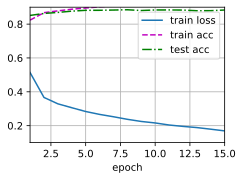

In [ ]:
# Train for 15 epochs
num_epochs = 15
train(net, train_iter, test_iter, loss, num_epochs, optimizer)

In [ ]:
# Note the accuracy varies a little bit but was observed to be always above 0.88
# Best Testing Accuracy = 0.8884
mu.evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8832